# https://www.kaggle.com/c/digit-recognizer/
# Score: 0.968, number: 1926

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [3]:
# load csv files to numpy arrays

def load_data():
    train = pd.read_csv("train.csv")
    print(train.shape)
    X_train = train.values[:,1:] 
    y_train = train.values[:,0]
    
    
    Pred_test = pd.read_csv("test.csv").values
    return X_train, y_train, Pred_test

x_train, y_train, pred_test = load_data()

(42000, 785)


In [4]:
print(x_train.shape, y_train.shape, pred_test.shape)

(42000, 784) (42000,) (28000, 784)


In [5]:

from sklearn.model_selection import train_test_split

# We use this function in order to evaulate a classifier. It trains on a fraction of the data corresponding to 
# aplit_ratio, and evaulates on the rest of the data

def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)


In [9]:
n_components_array=([1,2,3,4,5,10,15,20,35,50,75,100,110,130,170,200,210,500])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(x_train)
    vr[i] = sum(pca.explained_variance_ratio_)
    i=i+1

Text(0,0.5,'variance ratio')

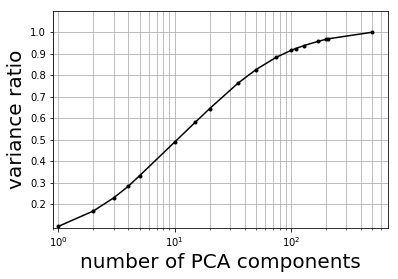

In [15]:
#plt.figure(plt.figsize(8,4))
plt.plot(n_components_array, vr, 'k.-')
plt.xscale("log")
plt.ylim(9e-2,1.1)
plt.yticks(np.linspace(0.2,1.0,9))
plt.xlim(0.9)
plt.grid(which="both")
plt.xlabel("number of PCA components",size=20)
plt.ylabel("variance ratio",size=20)

We see that ~100 PCA components are needed to capture ~90% of the variance in the data. This seems a lot of components. Maybe the more important question is: How good is our prediction as a function of number of components? Let's look at this next. We will train a kNN classifier on the PCA output.

In [18]:
%%time
knn = KNeighborsClassifier(n_neighbors = 5)

n_components_array=([1,2,3,4,5,10,15,20,35,50,75,100,110,130,170,200,210,500])
score_array = np.zeros(len(n_components_array))

i=0;
for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(x_train)
    transform_data = pca.transform(x_train)
    score_array[i] = evaluate_classifier(knn, transform_data, y_train, 0.8)
    i=i+1

/Users/vincent/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CPU times: user 10min 23s, sys: 11 s, total: 10min 34s
Wall time: 9min 58s


CPU times: user 14.7 ms, sys: 2.17 ms, total: 16.9 ms
Wall time: 15.2 ms


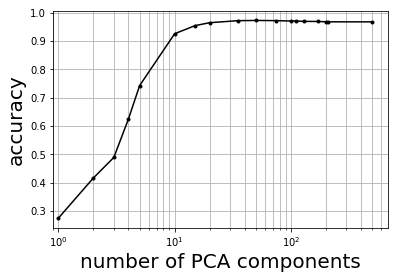

In [23]:
%%time

plt.plot(n_components_array, score_array, 'k.-')
plt.xscale("log")
#plt.ylim(9e-2,1.1)
#plt.yticks(np.linspace(0.2,1.0,9))
plt.xlim(0.9)
plt.grid(which="both")
plt.xlabel("number of PCA components",size=20)
plt.ylabel("accuracy",size=20)


### The accuracy seems to saturate at ~90% (roughly matching the performance of the random forest classifier) for >~20 PCA components. In fact, the accuracy even seems to drop for much larger numbers, even though a larger number of PCA components captures more of the variance in the data, as seen in the plot above. The drop in accuracy is probably due to overfitting.

In [24]:
%%time
pca = PCA(n_components=50)
pca.fit(x_train)
transform_data = pca.transform(x_train)
transform_test = pca.transform(pred_test)

knn.fit(transform_data, y_train)
predictions = knn.predict(transform_test)

CPU times: user 1min 5s, sys: 841 ms, total: 1min 6s
Wall time: 1min 4s


### Without PCA: took 28mins, so the PCA can save time (or memory)

In [26]:
def flush_predictons(predictions):
    imgs = pd.Series(range(1,pred_test.shape[0]+1))
    imgd = pd.DataFrame(imgs)
    
    labeld = pd.DataFrame(predictions)
    out = pd.concat([imgd, labeld],axis=1)
    out.columns = ["ImageId", "Label"]
    out.to_csv("KNN_PCA_Prediction.csv", index = False)

flush_predictons(predictions);

## The Score: 0.97300, better than the KNN without PCA.